## Get prediction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import numpy as np
import torch

sys.path.insert(0, '..')
from isegm.ritm.utils import vis, exp

from isegm.inference import utils
from isegm.ritm.inference.predictors import get_predictor
from isegm.ritm.model.is_explainable_ritm_hrnet_model import RitmHRNetModelExplainable
from isegm.data.preprocess import Preprocessor

device = torch.device('cuda:0')
cfg = exp.load_config_file('config.yml', return_edict=True)

In [3]:
EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49
TRAINING_OUTPUT_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training'
PRETRAINDED_WEIGHTS_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/weights'

# checkpoint_path = utils.find_checkpoint(PRETRAINDED_WEIGHTS_PATH, 'author_pretrained_ritm_32.pth')
checkpoint_path = utils.find_checkpoint_from_training(TRAINING_OUTPUT_PATH, 'RITM-dynamic clicks BceDice loss')
print(checkpoint_path)

saved_model = utils.load_is_model(checkpoint_path, 'cpu', model_type='RITM')

# saved_model = utils.load_is_model(checkpoint_path, 'cpu', train_config=train_config)
saved_model = saved_model.to('cpu')
model = RitmHRNetModelExplainable(
        pipeline_version='s2',
        width=32,
        ocr_width=128,
        small=False,
        with_aux_output=True,
        use_leaky_relu=True,
        use_rgb_conv=False,
        use_disks=True,
        norm_radius=5,
        with_prev_mask=True,
        dynamic_radius_points=True
    )
model.load_state_dict(saved_model.state_dict())
model = model.to(device)
model.eval()

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
# brs_mode = 'NoBRS'
brs_mode = 'NoBRSExplainable'

zoom_in_params = dict()
# zoom_in_params['skip_clicks'] = 0

predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH, zoom_in_params=zoom_in_params) 

/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/2024-02-15/16-42-10-RITM-dynamic clicks BceDice loss/checkpoints/best_model.pth
Model args: {'width': 32, 'ocr_width': 128, 'with_aux_output': True, 'use_leaky_relu': True, 'use_rgb_conv': False, 'use_disks': True, 'norm_radius': 5, 'with_prev_mask': True, 'dynamic_radius_points': True, 'model_type': 'RITM'}


In [4]:
# Possible choices: 'DAVIS', 'BRATS', 'LIDC', 'LIDC_2D_VAL', 'LIDC_2D_256_VAL', 'LIDC_CROPS_BOXED', 'LIDC_CROPS_WHITENED', 'LIDC_CROPS'
DATASET = 'LIDC_2D_VAL'
preprocessor = Preprocessor()
preprocessor.normalize = True
preprocessor.windowing = True
preprocessor.window_min = -900
preprocessor.window_max = 600
# preprocessor.convert_to_rgb = True

dataset = utils.get_dataset(DATASET, cfg, preprocessor=preprocessor)

[0.831 0.892 0.906 0.911 0.918 0.925 0.926 0.925 0.924 0.921 0.92  0.919
 0.921 0.93  0.934 0.934 0.934 0.934 0.934 0.934]


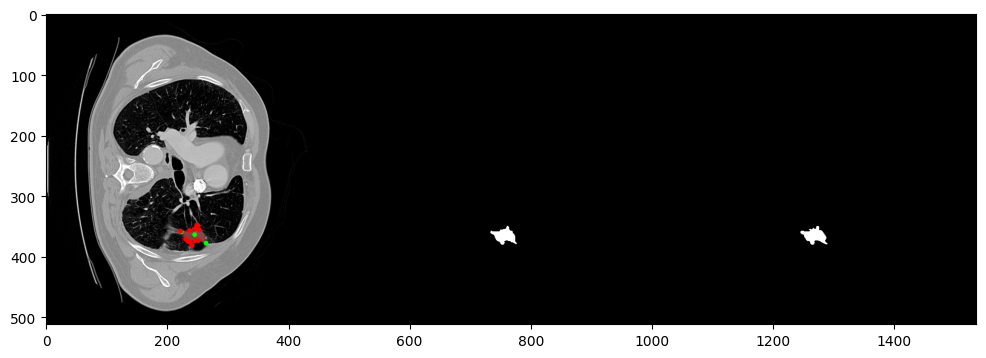

In [6]:
from isegm.inference.clicker import DynamicClicker
from isegm.ritm.inference.evaluation_explainable import evaluate_sample

sample_id = 8 # 28
TARGET_IOU = 1

use_init_mask = False

sample = dataset.get_sample(sample_id)

gt_mask = sample.gt_mask
image = sample.image
init_mask = np.zeros_like(gt_mask)

if use_init_mask and sample.init_mask is not None:
    init_mask = sample.init_mask
    
clicker = DynamicClicker(gt_mask = gt_mask, mode='avg')


clicks_list, ious_arr, pred, pred_list, info_list = evaluate_sample(image, gt_mask, predictor, 
                                              pred_thr=MODEL_THRESH, 
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS,
                                              clicker=clicker)

pred_mask = pred_list[-1] > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicks_list)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)
print(np.round(ious_arr, 3))
plt.figure(figsize=(12, 18))
plt.imshow(draw)
plt.show()

# Dist Maps

In [129]:
import torch
import torch.nn as nn
import numpy as np

class DistMaps(nn.Module):
    def __init__(self, norm_radius, spatial_scale=1.0, cpu_mode=False, dynamic_radius=False, mode='disk', use_disks=False, overwrite_maps=False):
        super(DistMaps, self).__init__()
        self.spatial_scale = spatial_scale
        self.norm_radius = norm_radius
        self.cpu_mode = cpu_mode
        self.use_disks = use_disks
        self.dynamic_radius = dynamic_radius
        self.overwrite_maps = overwrite_maps
        self.mode = mode
        
        self._warn_deperecation()
    
    def get_coord_features(self, points, batchsize, rows, cols):
        
        if self.mode == 'distance':
            # use legacy distance map implementation
            return self._get_distance_maps(points, batchsize, rows, cols)
        
        half_num_points = points.shape[1] // 2
        maps = torch.zeros((batchsize, 2, rows, cols), device=points.device)

        x_grid, y_grid = torch.meshgrid(torch.arange(rows, device=points.device), 
                                        torch.arange(cols, device=points.device), indexing='ij')

        for batch_idx in range(batchsize):
            for map_type in range(2):  # 0 for positive clicks, 1 for negative clicks
                for point_idx in range(half_num_points):
                    point = points[batch_idx, point_idx + (half_num_points * map_type)]
                    x, y, _, radius = point
                    if x < 0 or y < 0:  # Skip invalid points
                        continue

                    if self.mode == 'disk':
                        maps = self._draw_binary(x, y, radius, rows, cols, x_grid, y_grid, batch_idx, map_type, maps)
                    elif self.mode == 'gaussian':
                        maps = self._draw_gaussian(x, y, radius, x_grid, y_grid, batch_idx, map_type, maps)

        return maps.float()
    
    def _draw_binary(self, x, y, radius, rows, cols, x_grid, y_grid, batch_idx, map_type, maps):
        int_radius = int(torch.ceil(radius))
        x_min, x_max = max(0, int(x) - int_radius), min(rows, int(x) + int_radius + 1)
        y_min, y_max = max(0, int(y) - int_radius), min(cols, int(y) + int_radius + 1)
        mask = (x_grid[x_min:x_max, y_min:y_max] - x)**2 + (y_grid[x_min:x_max, y_min:y_max] - y)**2 <= radius**2
        maps[batch_idx, map_type, x_min:x_max, y_min:y_max][mask] = 1
        
        if self.overwrite_maps:
            maps[batch_idx, int(not map_type), x_min:x_max, y_min:y_max][mask] = 0
        
        return maps
    
    def _draw_gaussian(self, x, y, radius, x_grid, y_grid, batch_idx, map_type, maps):
        dx = x_grid - x
        dy = y_grid - y
        squared_distances = dx**2 + dy**2
        sigma = radius
        gaussian_map = torch.exp(-squared_distances / (sigma**2))
        maps[batch_idx, map_type, :, :] = torch.maximum(maps[batch_idx, map_type, :, :], gaussian_map)
        
        if self.overwrite_maps:
            maps[batch_idx, int(not map_type), :, :] = torch.minimum(maps[batch_idx, int(not map_type), :, :], 1 - gaussian_map)
        
        return maps
    
    def _get_distance_maps(self, points, batchsize, rows, cols):
        
        num_points = points.shape[1] // 2
        points = points.view(-1, points.size(2))
        points, points_order, _= torch.split(points, [2, 1, 1], dim=1)
        invalid_points = torch.max(points, dim=1, keepdim=False)[0] < 0
        row_array = torch.arange(
            start=0, end=rows, step=1, dtype=torch.float32, device=points.device
        )
        col_array = torch.arange(
            start=0, end=cols, step=1, dtype=torch.float32, device=points.device
        )
        
        coord_rows, coord_cols = torch.meshgrid(row_array, col_array)
        coords = (
            torch.stack((coord_rows, coord_cols), dim=0)
            .unsqueeze(0)
            .repeat(points.size(0), 1, 1, 1)
        )
        add_xy = (points * self.spatial_scale).view(
            points.size(0), points.size(1), 1, 1
        )
        coords.add_(-add_xy)
        coords.div_(self.norm_radius * self.spatial_scale)
        coords.mul_(coords)
        
        coords[:, 0] += coords[:, 1]
        coords = coords[:, :1]
        coords[invalid_points, :, :, :] = 1e6
        
        coords = coords.view(-1, num_points, 1, rows, cols)
        coords = coords.min(dim=1)[0]
        coords = coords.view(-1, 2, rows, cols)
        coords.sqrt_().mul_(2).tanh_()

        return coords

    def forward(self, x, coords):
        return self.get_coord_features(coords, x.shape[0], x.shape[2], x.shape[3])
    
    def _warn_deperecation(self):
        
        if self.use_disks:
            print(f'Property use_disks deprecated for DistMaps. Use mode=\'disk\' instead. Current mode: {mode}')
            
        if self.mode == 'distance':
            print(f'Distance map mode is bound to norm_radius. Current norm_radius: {self.norm_radius}')
        
        if self.cpu_mode:
            raise Exception('CPU mode is not supported')
            # from isegm.utils.cython import get_dist_maps
            # self._get_dist_maps = get_dist_maps
        
        print(f'{self.__class__} property dynamic_radius is deprecated. Click radius is decided by the clicker settings')

In [135]:
step_info = info_list[10]

In [136]:
test_clicks = step_info['image_transforms']['clicks_lists']
test_clicks = predictor.get_points_nd(test_clicks).cpu()
test_clicks

tensor([[[192.0000, 202.0000,   0.0000,  34.1662],
         [182.0000, 158.0000,   2.0000,   4.4363],
         [220.0000, 240.0000,   4.0000,   3.6504],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [228.0000, 194.0000,   1.0000,   8.8008],
         [216.0000, 184.0000,   3.0000,   3.5356],
         [160.0000, 210.0000,   5.0000,   2.1181],
         [162.0000, 214.0000,   6.0000,   1.0001],
         [170.0000, 206.0000,   7.0000,   1.0001],
         [172.0000, 204.0000,   8.0000,   1.0001],
         [176.0000, 218.0000,   9.0000,   1.0001],
         [178.0000, 186.0000,  10.0000,   1.0001]],

        [[192.0000, 197.0000,   0.0000,  34.1662],
         [182.0000, 241.0000,   2.0000,   4.4363],
         [220.0000, 159.0000,   4.0000,   3.6504],
         [ -1.0000,  -1.0000,

In [145]:
for click_list in test_clicks:
    for click in click_list:
        click[-1] = 5

In [146]:
print(test_clicks)

tensor([[[192., 202.,   0.,   5.],
         [182., 158.,   2.,   5.],
         [220., 240.,   4.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [228., 194.,   1.,   5.],
         [216., 184.,   3.,   5.],
         [160., 210.,   5.,   5.],
         [162., 214.,   6.,   5.],
         [170., 206.,   7.,   5.],
         [172., 204.,   8.,   5.],
         [176., 218.,   9.,   5.],
         [178., 186.,  10.,   5.]],

        [[192., 197.,   0.,   5.],
         [182., 241.,   2.,   5.],
         [220., 159.,   4.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [228., 205.,   1.,   5.],
         [216., 215.,   3.,   5.],
         [160., 189.,   5.,   5.],
         [162., 185.,   6.,   5.],
         [170., 19

<class '__main__.DistMaps'> property dynamic_radius is deprecated. Click radius is decided by the clicker settings


torch.Size([2, 2, 512, 512])


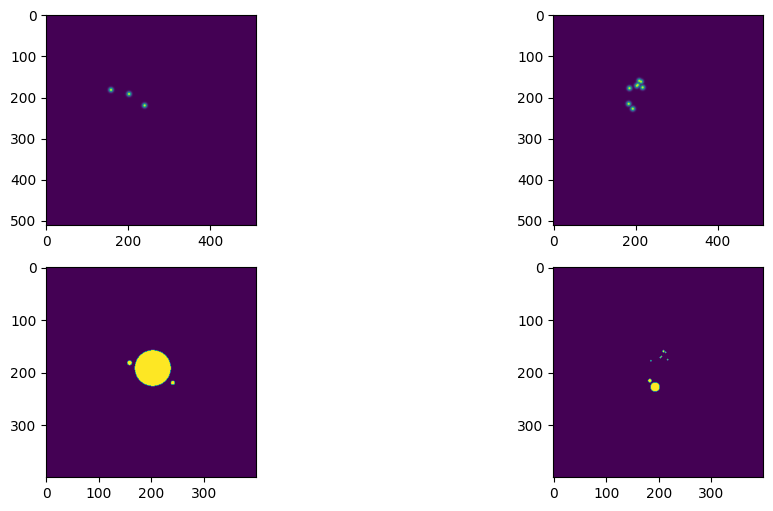

In [149]:
distmaps = DistMaps(5, mode='gaussian', overwrite_maps=False)
coords_map = distmaps.get_coord_features(test_clicks,2,512,512)
print(coords_map.shape)

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].imshow(coords_map[0,0])
ax[0, 1].imshow(coords_map[0,1])
# ax[0, 0].set_ylim([150,250])
# ax[0, 0].set_xlim([150,250])
ax[1, 0].imshow(step_info['coarse_seg']['click_map'][0, 0].cpu().numpy())
ax[1, 1].imshow(step_info['coarse_seg']['click_map'][0, 1].cpu().numpy())


In [ ]:
info

[(tensor([191., 174.,   0.,  25.]), False), (tensor([191., 199.,   1.,  20.]), True), (tensor([200., 215.,   2.,  10.]), False)]
torch.Size([1, 2, 512, 512])


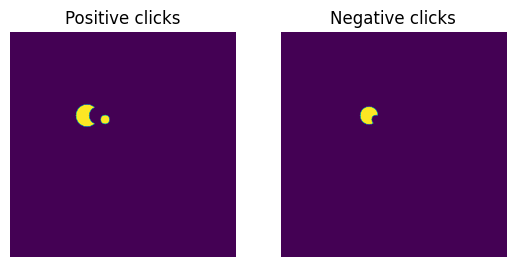

In [13]:
import torch
import torch.nn as nn
import numpy as np

class DistMaps(nn.Module):
    def __init__(self, norm_radius, spatial_scale=1.0, cpu_mode=False, use_disks=False, dynamic_radius=False, overwrite_maps=False):
        super(DistMaps, self).__init__()
        self.spatial_scale = spatial_scale
        self.norm_radius = norm_radius
        self.cpu_mode = cpu_mode
        self.use_disks = use_disks
        self.dynamic_radius = dynamic_radius
        self.overwrite_maps = overwrite_maps
        if self.cpu_mode:
            from isegm.utils.cython import get_dist_maps

            self._get_dist_maps = get_dist_maps

    def get_coord_features(self, points, batchsize, rows, cols):
        if self.dynamic_radius:
            return self.get_dynamic_disks(points, batchsize, rows, cols)
        
        if self.cpu_mode:
            coords = []
            for i in range(batchsize):
                norm_delimeter = (
                    1.0 if self.use_disks else self.spatial_scale * self.norm_radius
                )
                coords.append(
                    self._get_dist_maps(
                        points[i].cpu().float().numpy(), rows, cols, norm_delimeter
                    )
                )
            coords = (
                torch.from_numpy(np.stack(coords, axis=0)).to(points.device).float()
            )
        else:
            num_points = points.shape[1] // 2
            points = points.view(-1, points.size(2))
            points, points_order, _= torch.split(points, [2, 1, 1], dim=1)

            invalid_points = torch.max(points, dim=1, keepdim=False)[0] < 0
            row_array = torch.arange(
                start=0, end=rows, step=1, dtype=torch.float32, device=points.device
            )
            col_array = torch.arange(
                start=0, end=cols, step=1, dtype=torch.float32, device=points.device
            )

            coord_rows, coord_cols = torch.meshgrid(row_array, col_array)
            coords = (
                torch.stack((coord_rows, coord_cols), dim=0)
                .unsqueeze(0)
                .repeat(points.size(0), 1, 1, 1)
            )

            add_xy = (points * self.spatial_scale).view(
                points.size(0), points.size(1), 1, 1
            )
            coords.add_(-add_xy)
            if not self.use_disks:
                coords.div_(self.norm_radius * self.spatial_scale)
            coords.mul_(coords)

            coords[:, 0] += coords[:, 1]
            coords = coords[:, :1]

            coords[invalid_points, :, :, :] = 1e6

            coords = coords.view(-1, num_points, 1, rows, cols)
            coords = coords.min(dim=1)[0]  # -> (bs * num_masks * 2) x 1 x h x w
            coords = coords.view(-1, 2, rows, cols)

        if self.use_disks:
            coords = (coords <= (self.norm_radius * self.spatial_scale) ** 2).float()
        else:
            coords.sqrt_().mul_(2).tanh_()

        return coords
    
    def get_dynamic_disks(self, points, batchsize, rows, cols):
        half_num_points = points.shape[1] // 2
        
        maps = torch.zeros((batchsize, 2, rows, cols), device=points.device)

        x_grid, y_grid = torch.meshgrid(torch.arange(rows, device=points.device), 
                                        torch.arange(cols, device=points.device), indexing='ij')

        for batch_idx in range(batchsize):
            
            # False - positive map, True - negative map
            points_with_maps = [(point, i >= half_num_points) for i, point in enumerate(points[batch_idx])]
        
            #filter out invalid clicks and sort
            points_with_maps = [point_map_pair for point_map_pair in points_with_maps if point_map_pair[0][2] > -1]
            points_with_maps = sorted(points_with_maps, key=lambda pair: pair[0][2])
            print(points_with_maps)
            
            for point, map_idx in points_with_maps:
                x, y, _, radius = point
                
                int_radius = int(torch.ceil(radius))
                x_min, x_max = max(0, int(x) - int_radius), min(rows, int(x) + int_radius + 1)
                y_min, y_max = max(0, int(y) - int_radius), min(cols, int(y) + int_radius + 1)
                
                mask = (x_grid[x_min:x_max, y_min:y_max] - x)**2 + (y_grid[x_min:x_max, y_min:y_max] - y)**2 <= radius**2
                maps[batch_idx, int(map_idx), x_min:x_max, y_min:y_max][mask] = 1
                
                if self.overwrite_maps:
                    maps[batch_idx, int(not map_idx), x_min:x_max, y_min:y_max][mask] = 0

        return maps.float()
    

    
distmaps = DistMaps(5, use_disks=True, dynamic_radius=True, cpu_mode=False, overwrite_maps=True)
test_clicks = torch.tensor([[[191., 174.,   0.,   25.], [200, 215, 2, 10],[191., 199.,   1.,   20.], [-1,-1,-1,-1]],[[191., 174.,   0.,   25.], [191, 174, 2, 15],[191., 174.,   1.,   20.], [-1,-1,-1,-1]]])
coords_map = distmaps.get_coord_features(test_clicks, 1, 512, 512)
print(coords_map.shape)
fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Positive clicks')
ax[1].set_title('Negative clicks')
ax[0].imshow(coords_map[0,0])
ax[1].imshow(coords_map[0,1])

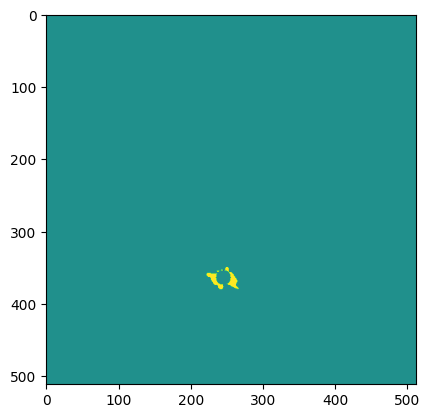

In [10]:
import numpy as np
from scipy.ndimage import label, distance_transform_edt
import matplotlib.pyplot as plt

def find_largest_component(binary_mask):
    distance = distance_transform_edt(binary_mask)
    labeled_mask, num_features = label(binary_mask)
    max_dist_coords = np.unravel_index(np.argmax(distance), distance.shape)
    largest_component_label = labeled_mask[max_dist_coords]
    largest_component_mask = (labeled_mask == largest_component_label)
    return largest_component_mask, max_dist_coords, distance[max_dist_coords]

def generate_disk_in_component(binary_mask, center, max_radius):
    disk_mask = np.zeros_like(binary_mask)
    for x in range(disk_mask.shape[0]):
        for y in range(disk_mask.shape[1]):
            if np.sqrt((x - center[0])**2 + (y - center[1])**2) <= max_radius:
                disk_mask[x, y] = 1
    return disk_mask

# Example usage
binary_mask = gt_mask
largest_component_mask, center, max_radius = find_largest_component(binary_mask)

# Generate the disk
disk_mask = generate_disk_in_component(largest_component_mask, center, max_radius)

# Visualize the result
plt.imshow(gt_mask - disk_mask)
plt.show()


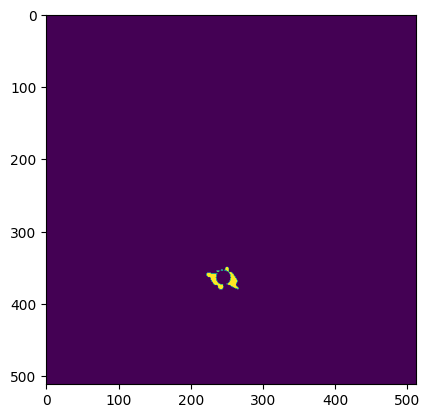

In [11]:
binary_mask = gt_mask - disk_mask
binary_mask[binary_mask > 0] = 1
binary_mask[binary_mask < 1] = 0
plt.imshow(binary_mask)

## Visualise each part

In [66]:
step_info = info_list[19]

In [119]:
clicks = clicker.get_clicks()

In [120]:
for c in clicks:
    print(c.description)

(191, 174), True, 9.0
(180, 180), False, 1.0
(195, 186), False, 1.0
(196, 184), False, 1.0
(178, 170), True, 1.0
(178, 177), True, 1.0
(199, 179), True, 1.0
(0, 0), False, 0.0
(198, 182), False, 1.0
(184, 181), True, 1.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0
(0, 0), False, 0.0


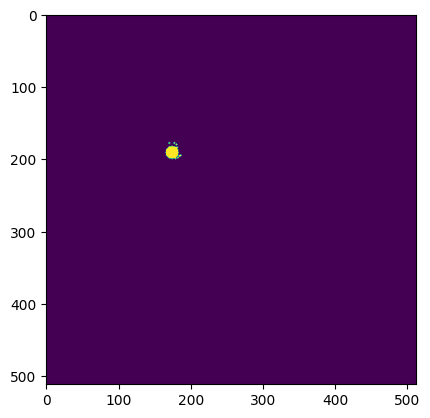

In [121]:
plt.imshow(np.invert(clicker.not_clicked_map))

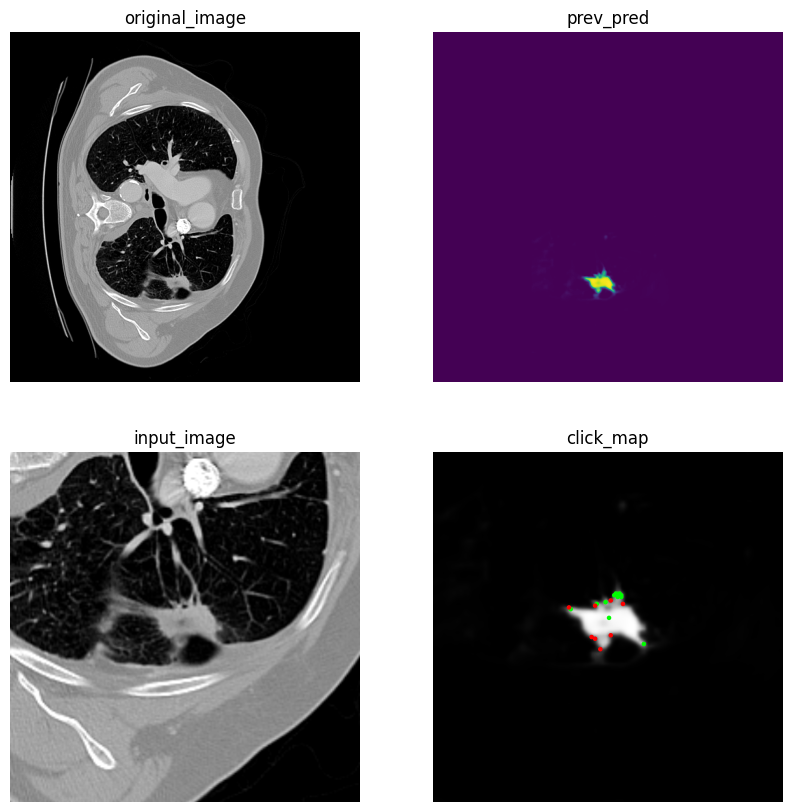

In [83]:
def show_before_coarse(info):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.close()
    
    ax[0,0].set_title('original_image')
    ax[0,0].imshow(info['original_image'][0], cmap='gray')
    ax[0,0].axis('off')
    
    ax[0,1].set_title('prev_pred')
    ax[0,1].imshow(info['prev_mask'])
    ax[0,1].axis('off')
    
    ax[1,0].set_title(f'input_image')
    ax[1,0].imshow(info['image_transforms']['image_nd'].cpu()[0, 0], cmap='gray')
    ax[1,0].axis('off')
    
    ax[1,1].set_title('click_map')
    ax[1,1].imshow(info['image_transforms']['image_nd'].cpu()[0, 3], cmap='gray')
    ax[1,1].axis('off')
    y = [click.coords[0] for click in info['image_transforms']['clicks_lists'][0]]
    x = [click.coords[1] for click in info['image_transforms']['clicks_lists'][0]]
    c = [click.is_positive for click in info['image_transforms']['clicks_lists'][0]]
    c = ['lime' if i else 'red' for i in c]
    ax[1,1].scatter(x, y, c=c, s=5)
    
    return fig

show_before_coarse(step_info)

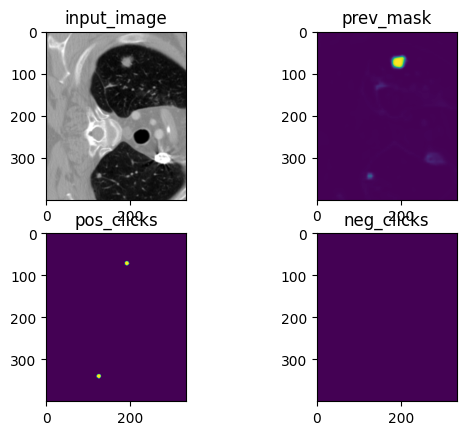

In [15]:
def show_coarse_input(info):
    
    info = info['coarse_seg']
    
    fig, ax = plt.subplots(2, 2)
    plt.close()
    
    ax[0, 0].set_title('input_image')
    ax[0, 0].imshow(info['prepared_input']['image'].cpu()[0, 0], cmap='gray')
    
    ax[0, 1].set_title('prev_mask')
    ax[0, 1].imshow(info['prepared_input']['prev_mask'].cpu()[0, 0])
    
    ax[1, 0].set_title('pos_clicks')
    ax[1, 0].imshow(info['click_map'].cpu()[0, 0])
    
    ax[1, 1].set_title('neg_clicks')
    ax[1, 1].imshow(info['click_map'].cpu()[0, 1])
    
    return fig

show_coarse_input(step_info)

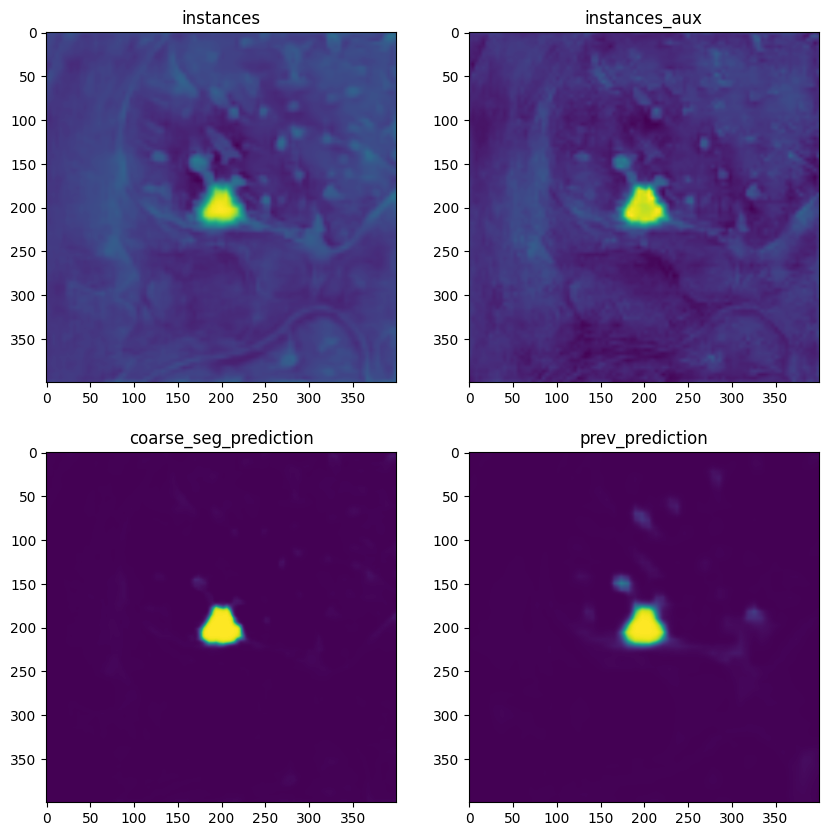

In [11]:
def show_coarse_predictions(info):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.close()
    
    ax[0, 0].set_title('instances')
    ax[0, 0].imshow(info['coarse_seg']['outputs']['instances'].cpu()[0, 0])
    
    ax[0, 1].set_title('instances_aux')
    ax[0, 1].imshow(info['coarse_seg']['outputs']['instances_aux'].cpu()[0, 0])
    
    ax[1, 0].set_title('coarse_seg_prediction')
    new_mask = torch.sigmoid(info['coarse_seg']['outputs']['instances'].cpu()[0, 0]).numpy()
    ax[1, 0].imshow(new_mask)
    
    ax[1,1].set_title('prev_prediction')
    ax[1,1].imshow(info['coarse_seg']['prepared_input']['prev_mask'].cpu()[0, 0])
    
    return fig

show_coarse_predictions(step_info)

## Animation code

In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import base64

def show_animation(animation):
    html = animation.to_jshtml()
    
    return HTML(html)

def show_animation_from_file(filename):
    
    with open(filename, 'rb') as f:
        gif_data = f.read()

    gif_base64 = base64.b64encode(gif_data).decode('utf-8')

    html_code = f'<img src="data:image/gif;base64,{gif_base64}">'
    return HTML(html_code)

def save_animation(animation, filename):
    animation.save(f'{filename}.gif', writer='pillow')
    
def generate_click_animation(image, gt_mask, iou_values, clicks, predictions, info_list):
    fig, ax = plt.subplots(2, 3, figsize=(9, 7))
    if len(image.shape) == 3:
        image = image[:, :, 0]
        
    num_frames = len(clicks)
        
    ax[0,0].imshow(image, cmap='gray')
    ax[0,0].axis('off')
    ax[0,0].set_title('Image, gt mask,\nClicks', fontsize=20)
    ax[0,0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)

    ax[1, 1].set_title('Coarse logits')
    
    plt.close()
    
    def update(frame_index):
        
        fig.suptitle(f'Click {frame_index + 1}', fontsize=20)
        
        ax[0,0].imshow(image, cmap='gray')
        ax[0,0].set_title(f'Clicks: {frame_index + 1}', fontsize=20)
        ax[0,0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)
        for click in clicks[:frame_index + 1]:
            color = 'lime' if click.is_positive else 'r'
            y, x = click.coords
            ax[0,0].scatter(x, y, s=10, c=color)
            
        ax[0,1].clear()
        ax[0,1].set_title('Previous predicition', fontsize=20)
        ax[0,1].axis('off')
        ax[0,1].imshow(info_list[frame_index]['prev_mask'])
        
        ax[0,2].clear()
        ax[0,2].axis('off')
        ax[0,2].set_title(f'Input image', fontsize=20)
        ax[0,2].imshow(info_list[frame_index]['image_transforms']['image_nd'].cpu()[0, 0], cmap='gray')
        
        # image_transforms = info_list[frame_index]['image_transforms']
        # ax[1,0].clear()
        # ax[1,0].set_title('Click map', fontsize=20)
        # ax[1,0].axis('off')
        # ax[1,0].imshow(image_transforms['image_nd'].cpu()[0, 3], cmap='gray')
        
        ax[1,0].clear()
        ax[1,0].axis('off')
        ax[1,0].set_title('Positive clicks', fontsize=20)
        ax[1,0].imshow(info_list[frame_index]['coarse_seg']['click_map'].cpu()[0, 0])
    
        ax[1,1].clear()
        ax[1,1].axis('off')
        ax[1,1].set_title('Negative clicks', fontsize=20)
        ax[1,1].imshow(info_list[frame_index]['coarse_seg']['click_map'].cpu()[0, 1])
        
        # start_y, end_y, start_x, end_x = info_list[frame_index]['global_roi']
        # cur_clicks = image_transforms['clicks_lists'][0]
        # y = [click.coords[0] for click in image_transforms['clicks_lists'][0]]
        # x = [click.coords[1] for click in image_transforms['clicks_lists'][0]]
        # c = [click.is_positive for click in image_transforms['clicks_lists'][0]]
        # c = ['lime' if i else 'red' for i in c]
        # ax[1,0].scatter(x, y, c=c, s=20)
        
        ax[1,2].clear()
        ax[1,2].set_title('Coarse prediction', fontsize=20)
        ax[1,2].axis('off')
        ax[1,2].imshow(info_list[frame_index]['coarse_seg_prediction'])
        
        # ax[1,2].clear()
        # ax[1,2].axis('off')
        # ax[1,2].set_title(f'Final prediction', fontsize=20)
        # ax[1,2].imshow(predictions[frame_index])
        
        return
    
    animation = FuncAnimation(fig, update, frames=num_frames, interval=1000, blit=False)
    return animation

In [11]:
anim = generate_click_animation(image, gt_mask, ious_arr, clicks_list, pred_list, info_list)
show_animation(anim)

# Training

In [8]:
MAX_NUM_NEXT_CLICKS = 3

In [9]:
def get_points_from_clicks(clicker):
    clicks_list = clicker.get_clicks()
    total_clicks = []
    num_pos_clicks = sum(x.is_positive for x in clicks_list)
    num_neg_clicks = len(clicks_list) - num_pos_clicks
    num_max_points = num_pos_clicks + num_neg_clicks
    num_max_points = max(1, num_max_points)
        
    pos_clicks = [click.as_tuple for click in clicks_list if click.is_positive]
    pos_clicks = pos_clicks + (num_max_points - len(pos_clicks)) * [(-1, -1, -1, -1)]
    neg_clicks = [click.as_tuple for click in clicks_list if not click.is_positive]
    neg_clicks = neg_clicks + (num_max_points - len(neg_clicks)) * [(-1, -1, -1, -1)]
    total_clicks.append(pos_clicks + neg_clicks)
    return torch.tensor(total_clicks)

In [10]:
from isegm.model.losses import NormalizedFocalLossSigmoid, SigmoidBinaryCrossEntropyLoss, WFNL
from easydict import EasyDict as edict

import torch.nn.functional as F
import torch.nn as nn

class ClickDiceLoss(nn.Module):
    def __init__(self, eps=1e-6, weight=None, batch_axis=0):
        super(ClickDiceLoss, self).__init__()
        self.eps = eps
        self.weight = weight if weight is not None else 1.0
        self.batch_axis = batch_axis

    # def forward(self, pred, target, click_map):
    #     pos_clicks = click_map[:,0].bool()
    #     target = target.bool()
        
    #     # Compute regions for oversegmentation penalty
    #     shouldnt_segment = torch.bitwise_and(torch.bitwise_xor(target, pos_clicks), pos_clicks)

    #     # Adjust pred to only consider the positive click area
    #     pred_in_click_area = torch.bitwise_and(pred > 0.5, pos_clicks)
        
    #     oversegmented_size = shouldnt_segment.sum()
    #     undersegmented_size = (target & ~pred).sum()

    #     print("Oversegmented region size:", oversegmented_size.item())
    #     print("Undersegmented region size:", undersegmented_size.item())


    #     # Calculate intersection and union for oversegmented region within the positive click area
    #     intersection_overseg = (pred_in_click_area * shouldnt_segment).sum(dim=self.batch_axis)
    #     union_overseg = pred_in_click_area.sum(dim=self.batch_axis) + shouldnt_segment.sum(dim=self.batch_axis)

    #     # Calculate Dice loss for oversegmented region within the positive click area
    #     dice_loss_overseg = 1 - (2 * intersection_overseg + self.eps) / (union_overseg + self.eps)

    #     # Apply weight and return
    #     return self.weight * dice_loss_overseg.mean()

    def forward(self, pred, target, click_map):
        pos_clicks = click_map[:, 0].bool()
        target = target.bool()

        # Compute regions for oversegmentation penalty
        shouldnt_segment = torch.bitwise_and(torch.bitwise_xor(target, pos_clicks), pos_clicks)

        # Adjust pred to only consider the positive click area and convert to probabilities
        pred_in_click_area = torch.sigmoid(pred) * pos_clicks
        pred_in_click_area = torch.clamp(pred_in_click_area, min=1e-6, max=1-1e-6)  # Avoid 0 and 1

        # Calculate Binary Cross-Entropy for the Focal Loss
        bce_loss = F.binary_cross_entropy(pred_in_click_area, shouldnt_segment.float(), reduction='none')

        # Calculate the Focal Loss
        alpha = 0.75
        gamma = 2.0
        epsilon = 1e-6  # Small value to avoid numerical instability
        pt = torch.where(shouldnt_segment, pred_in_click_area, 1 - pred_in_click_area)
        focal_loss = alpha * ((1 - pt) ** gamma) * bce_loss

        # Normalize focal loss, avoiding division by zero
        normalization_factor = pos_clicks.sum(dim=self.batch_axis) + epsilon
        focal_loss = focal_loss.sum(dim=self.batch_axis) / normalization_factor

        # Apply weight and return
        return self.weight * focal_loss.mean()

def add_loss(loss_name, total_loss, losses_logging, validation, lambda_loss_inputs
    ):
        loss_cfg = edict()
        loss_cfg.instance_loss = NormalizedFocalLossSigmoid(alpha=0.5, gamma=2)
        loss_cfg.instance_loss_weight = 1.0
        loss_cfg.instance_aux_loss = SigmoidBinaryCrossEntropyLoss()
        loss_cfg.instance_aux_loss_weight = 0.4
        # loss_cfg.oversegmenting_loss = ClickDiceLoss()
        # loss_cfg.oversegmenting_loss_weight = 0.5
        loss_cfg.pre_stage_features_loss = NormalizedFocalLossSigmoid(alpha=0.5, gamma=2)
        loss_cfg.pre_stage_features_loss_weight = 1.0
        
        loss_weight = loss_cfg.get(loss_name + '_weight', 0.0)
        if loss_weight > 0.0:
            loss_criterion = loss_cfg.get(loss_name)
            loss = loss_criterion(*lambda_loss_inputs())
            loss = torch.mean(loss)
            losses_logging[loss_name] = loss
            loss = loss_weight * loss
            total_loss = total_loss + loss

        return total_loss

In [11]:

def get_next_points(pred, gt, points, click_indx, pred_thresh=0.49):
    assert click_indx > 0
    pred = pred.cpu().numpy()[:, 0, :, :]
    gt = gt.cpu().numpy()[:, 0, :, :] > 0.5
    fn_mask = np.logical_and(gt, pred < pred_thresh)
    fp_mask = np.logical_and(np.logical_not(gt), pred > pred_thresh)
    fn_mask = np.pad(fn_mask, ((0, 0), (1, 1), (1, 1)), "constant").astype(np.uint8)
    fp_mask = np.pad(fp_mask, ((0, 0), (1, 1), (1, 1)), "constant").astype(np.uint8)
    num_points = points.size(1) // 2
    points = points.clone()
    for bindx in range(fn_mask.shape[0]):
        fn_mask_dt = cv2.distanceTransform(fn_mask[bindx], cv2.DIST_L2, 5)[1:-1, 1:-1]
        fp_mask_dt = cv2.distanceTransform(fp_mask[bindx], cv2.DIST_L2, 5)[1:-1, 1:-1]
        fn_max_dist = np.max(fn_mask_dt)
        fp_max_dist = np.max(fp_mask_dt)
        is_positive = fn_max_dist > fp_max_dist
        dt = fn_mask_dt if is_positive else fp_mask_dt
        inner_mask = dt > max(fn_max_dist, fp_max_dist) / 2.0
        indices = np.argwhere(inner_mask)
        if len(indices) > 0:
            coords = indices[np.random.randint(0, len(indices))]
            if is_positive:
                points[bindx, num_points - click_indx, 0] = float(coords[0])
                points[bindx, num_points - click_indx, 1] = float(coords[1])
                points[bindx, num_points - click_indx, 2] = float(click_indx)
            else:
                points[bindx, 2 * num_points - click_indx, 0] = float(coords[0])
                points[bindx, 2 * num_points - click_indx, 1] = float(coords[1])
                points[bindx, 2 * num_points - click_indx, 2] = float(click_indx)
    return points

In [12]:
prev_mask_drop_prob = 0
max_interactive_points = 24

clicker_config = {
    'mode':'max',
    'size_range_modifier': 0
}

In [ ]:
import random
import time

import torch.nn.functional as F

def batch_forward(batch_data, validation=False):
    # metrics = self.val_metrics if validation else self.train_metrics
    losses_logging = dict()
    info = []
    with torch.set_grad_enabled(not validation):
        image, gt_mask = (
            batch_data["images"],
            batch_data["instances"],
        )
        image = image.to(device)
        gt_mask = gt_mask.to(device)
        
        pts = batch_data['points'][0]
        counted = sum(p[0] > -1 for p in pts)
        total_num_clicks = counted
        print(total_num_clicks)
        # total_num_clicks = 1
        
        # total_num_clicks = np.random.randint(1, max_interactive_points) # total num points

        prev_output = torch.zeros_like(image, dtype=torch.float32)[:, :1, :, :]
        clickers = []
        for gt in gt_mask:
            clicker = DynamicClicker(gt_mask=gt.squeeze(0).cpu(),
                                     mode=clicker_config['mode'],
                                     size_range_modifier=clicker_config['size_range_modifier'])
            clickers.append(clicker)
        last_click_indx = None
        
        num_iters = total_num_clicks - 1 # leaves one more click for backprop
        print(f'num_iters: {num_iters}')
        print(f'total num clicks: {total_num_clicks}')
        num_remaining_clicks = max(total_num_clicks - num_iters, 1) # make at least one click withbackprop
        print(f'backprop_clicks: {num_remaining_clicks}')
        
        with torch.no_grad():
            inference_info = []
            
            for click_indx in range(num_iters):
                last_click_indx = click_indx
                if not validation:
                    model.eval()
                    
                # if self.click_models is None or click_indx >= len(
                #     self.click_models
                # ):
                #     eval_model = self.net
                # else:
                #     eval_model = self.click_models[click_indx]
                eval_model = model
                
                iter_points = torch.empty((0, 2 * (click_indx + 1), 4))
                for clicker, prev_prediction in zip(clickers, prev_output):
                    clicker.make_next_click(prev_prediction.squeeze(0).cpu().numpy() > 0.5)
                    current_points = get_points_from_clicks(clicker)
                    iter_points = torch.cat((iter_points, current_points), dim=0)
                iter_points = iter_points.to(device)
                
                net_input = (
                    torch.cat((image, prev_output), dim=1)
                    if model.with_prev_mask
                    else image
                )
                
                out, iter_info = eval_model(net_input, iter_points)
                
                prev_mask = prev_output.cpu().detach()
                
                prev_output = torch.sigmoid(
                     out["instances"]
                )
                
                inference_info.append({
                        'image': image.cpu(),
                        'prev_mask': prev_mask,
                        'points': iter_points.cpu(),
                        'ouput': prev_output,
                        'model_info': iter_info
                    })
                

                if not validation:
                    model.train()
            if (
                model.with_prev_mask
                and prev_mask_drop_prob > 0
                and last_click_indx is not None
            ):
                zero_mask = (
                    np.random.random(size=prev_output.size(0))
                    < prev_mask_drop_prob
                )
                prev_output[zero_mask] = torch.zeros_like(prev_output[zero_mask])
                
                
        backprop_points = torch.empty((0, 2 * total_num_clicks, 4))
        for clicker, prev_prediction in zip(clickers, prev_output):
            clicker.make_next_click(prev_prediction.squeeze(0).cpu().numpy() > 0.5)
            current_points = get_points_from_clicks(clicker)
            backprop_points = torch.cat((backprop_points, current_points), dim=0)
        backprop_points = backprop_points.to(device)

        net_input = (
            torch.cat((image, prev_output), dim=1)
            if model.with_prev_mask
            else image
        )
        
        print(net_input.device, backprop_points.device)
        output, model_info = model(net_input, backprop_points)
        
        info.append({
                # 'inference_info': inference_info,
                'input_images': net_input.cpu().detach(),
                'input_points': backprop_points.cpu().detach(),
                'outputs':output,
                'new_masks': torch.sigmoid(output['instances'].cpu().detach()),
                'model_info': model_info
            })
        
        loss = 0.0
        loss = add_loss(
            "instance_loss",
            loss,
            losses_logging,
            validation,
            lambda: (output["instances"], gt_mask),
        )
        loss = add_loss(
            "instance_aux_loss",
            loss,
            losses_logging,
            validation,
            lambda: (output["instances_aux"], gt_mask),
        )
        # loss = add_loss(
        #     "oversegmenting_loss",
        #     loss,
        #     losses_logging,
        #     validation,
        #     lambda: (output["instances"], gt_mask, output["click_map"]),
        # )
        downsized_masks = F.interpolate(gt_mask, size=(128, 128), mode='nearest')
        loss = add_loss(
            "pre_stage_features_loss",
            loss,
            losses_logging,
            validation,
            lambda: (output["pre_stage_features"], downsized_masks),
        )
        
        loss = 0.0
        # if self.is_master:
        #     with torch.no_grad():
        #         for m in metrics:
        #             m.update(
        #                 *(output.get(x) for x in m.pred_outputs),
        #                 *(batch_data[x] for x in m.gt_outputs),
        #             )
    return (
        loss,
        losses_logging,
        info
    )

In [ ]:
from albumentations import Compose, RandomCrop, PadIfNeeded, HorizontalFlip
from isegm.data.transforms import UniformRandomResize
from torch.utils.data import DataLoader
from isegm.utils.distributed import get_dp_wrapper, get_sampler, reduce_loss_dict

train_augmentator = Compose(
            [
                # UniformRandomResize(scale_range=(0.75, 1.40)),
                HorizontalFlip(),
                PadIfNeeded(
                    min_height=256, min_width=256, border_mode=0
                ),
                # RandomCrop(256, 256),
            ],
            p=1.0,
        )
dataset.augmentator = train_augmentator

train_data = DataLoader(
    dataset,
    1,
    shuffle=False,
    sampler=get_sampler(dataset, shuffle=False, distributed=False),
    drop_last=False,
    pin_memory=True,
    num_workers=0
)
iterat = iter(train_data)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch = next(iterat)
train_batch['images'] = torch.cat((train_batch['images'], train_batch['images']), dim=0)
train_batch['points'] = torch.cat((train_batch['points'], train_batch['points']), dim=0)
train_batch['instances'] = torch.cat((train_batch['instances'], train_batch['instances']), dim=0)
# train_batch = next(iterat)

In [15]:
# train_batch = next(iterat)
strt = time.time()
avg_loss, losses_logging, info = batch_forward(train_batch)
end = time.time()


num_iters: 0
total num clicks: 1
backprop_clicks: 1
cuda:0 cuda:0


In [26]:
losses_logging

{'instance_loss': tensor(0.6292, device='cuda:0', grad_fn=<MeanBackward0>),
 'instance_aux_loss': tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>),
 'pre_stage_features_loss': tensor(26.4857, device='cuda:0', grad_fn=<MeanBackward0>)}

[(364, 245, 0, 17.08309555053711)]


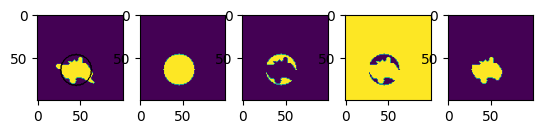

In [ ]:
clicker = DynamicClicker(gt_mask = gt_mask, mode='avg', allow_overlap=False)
pred_mask = np.zeros_like(gt_mask)
clicker.make_next_click(pred_mask)
print([c.as_tuple for c in clicker.get_clicks()])
click_map = np.bitwise_not(clicker.not_clicked_map)
click_map =  click_map[300:400,200:300]
target = gt_mask[300:400,200:300]
fig, ax = plt.subplots(1,5)
ax[0].imshow(cropped_mask)
ax[0].contour(click_map, colors='black', alpha=1, linewidths=0.2)
ax[1].imshow(click_map)

# a = ax[2].imshow(cropped_mask - click_map)
pos_clicks = click_map
neg_clicks = click_map

shouldnt_segment = np.bitwise_and(np.bitwise_xor(target, pos_clicks), pos_clicks)
should_segment = np.bitwise_and(np.bitwise_xor(target, pos_clicks), np.bitwise_not(neg_clicks))

target = torch.tensor(target).bool()
pos_clicks = torch.tensor(pos_clicks).bool()
neg_clicks = torch.tensor(neg_clicks).bool()
shouldnt_segment = torch.bitwise_and(torch.bitwise_xor(target, pos_clicks), pos_clicks)
should_segment = ~shouldnt_segment
# shouldnt_segment = torch.bitwise_and(shouldnt_segment, target)

new_target = ~torch.bitwise_xor(should_segment, pos_clicks)
# new_target = torch.bitwise_xor(shouldnt_segment, pos_clicks)

ax[2].imshow(shouldnt_segment)
ax[3].imshow(should_segment)

ax[4].imshow(new_target)

In [ ]:
def show_step(step_info):
    num_samples = step_info['input_images'].shape[0]
    fig, ax = plt.subplots(num_samples, 5, figsize=(num_samples * 10, num_samples*4))
    
    for i in range(num_samples):
        ax[i, 0].imshow(step_info['model_info']['prepared_input']['image'][i, 0].cpu(), cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_title('Input image')
        
        ax[i, 1].imshow(step_info['model_info']['prepared_input']['prev_mask'].cpu()[i, 0])
        ax[i, 1].axis('off')
        ax[i, 1].set_title('Prev mask')
        
        ax[i, 2].imshow(step_info['model_info']['coord_features'].cpu()[i, 1])
        ax[i, 2].axis('off')
        ax[i, 2].set_title('Positive Clicks')
        
        ax[i, 3].imshow(step_info['model_info']['coord_features'].cpu()[i, 2])
        ax[i, 3].axis('off')
        ax[i, 3].set_title('Negative Clicks')
        
        ax[i, 4].imshow(step_info['new_masks'].cpu()[i, 0] > 0.5)
        ax[i, 4].axis('off')
        ax[i, 4].set_title('New Masks')

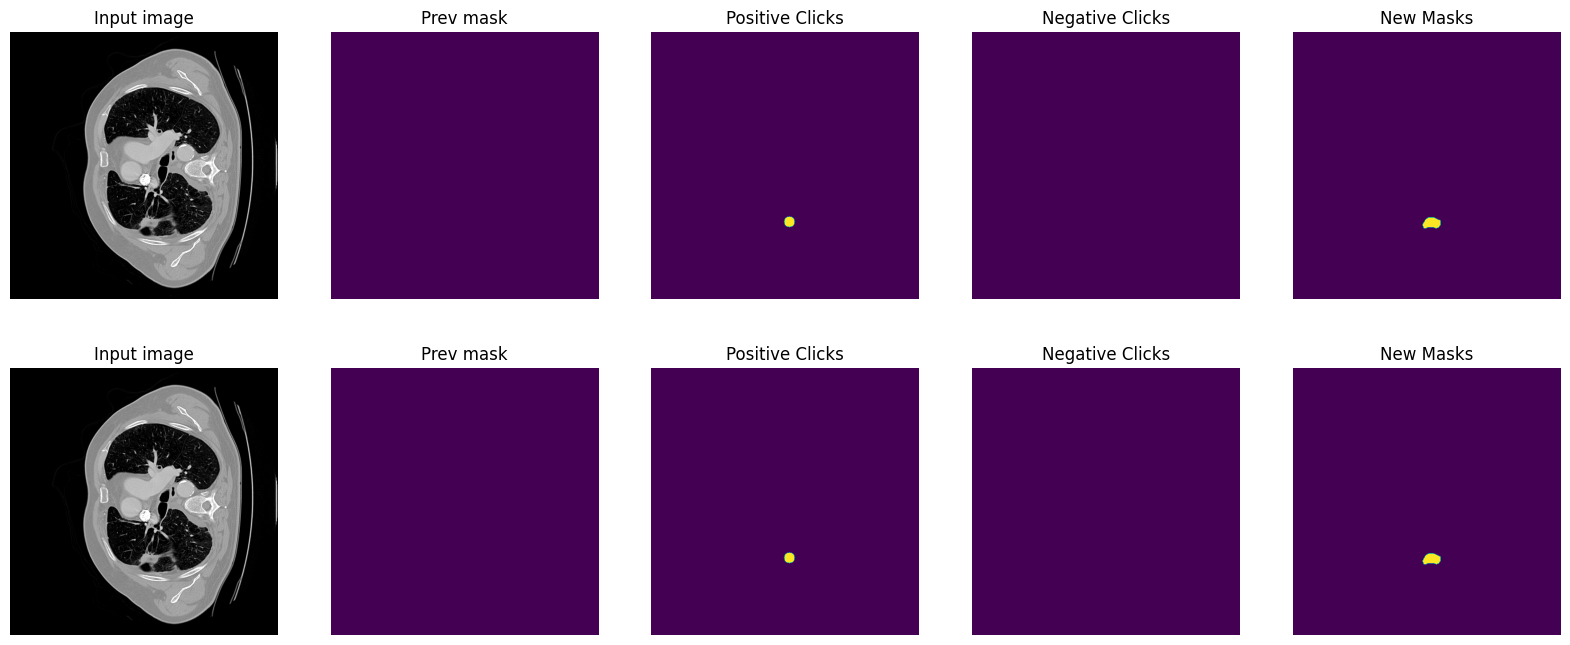

In [ ]:
step_info = info[0]
show_step(step_info)

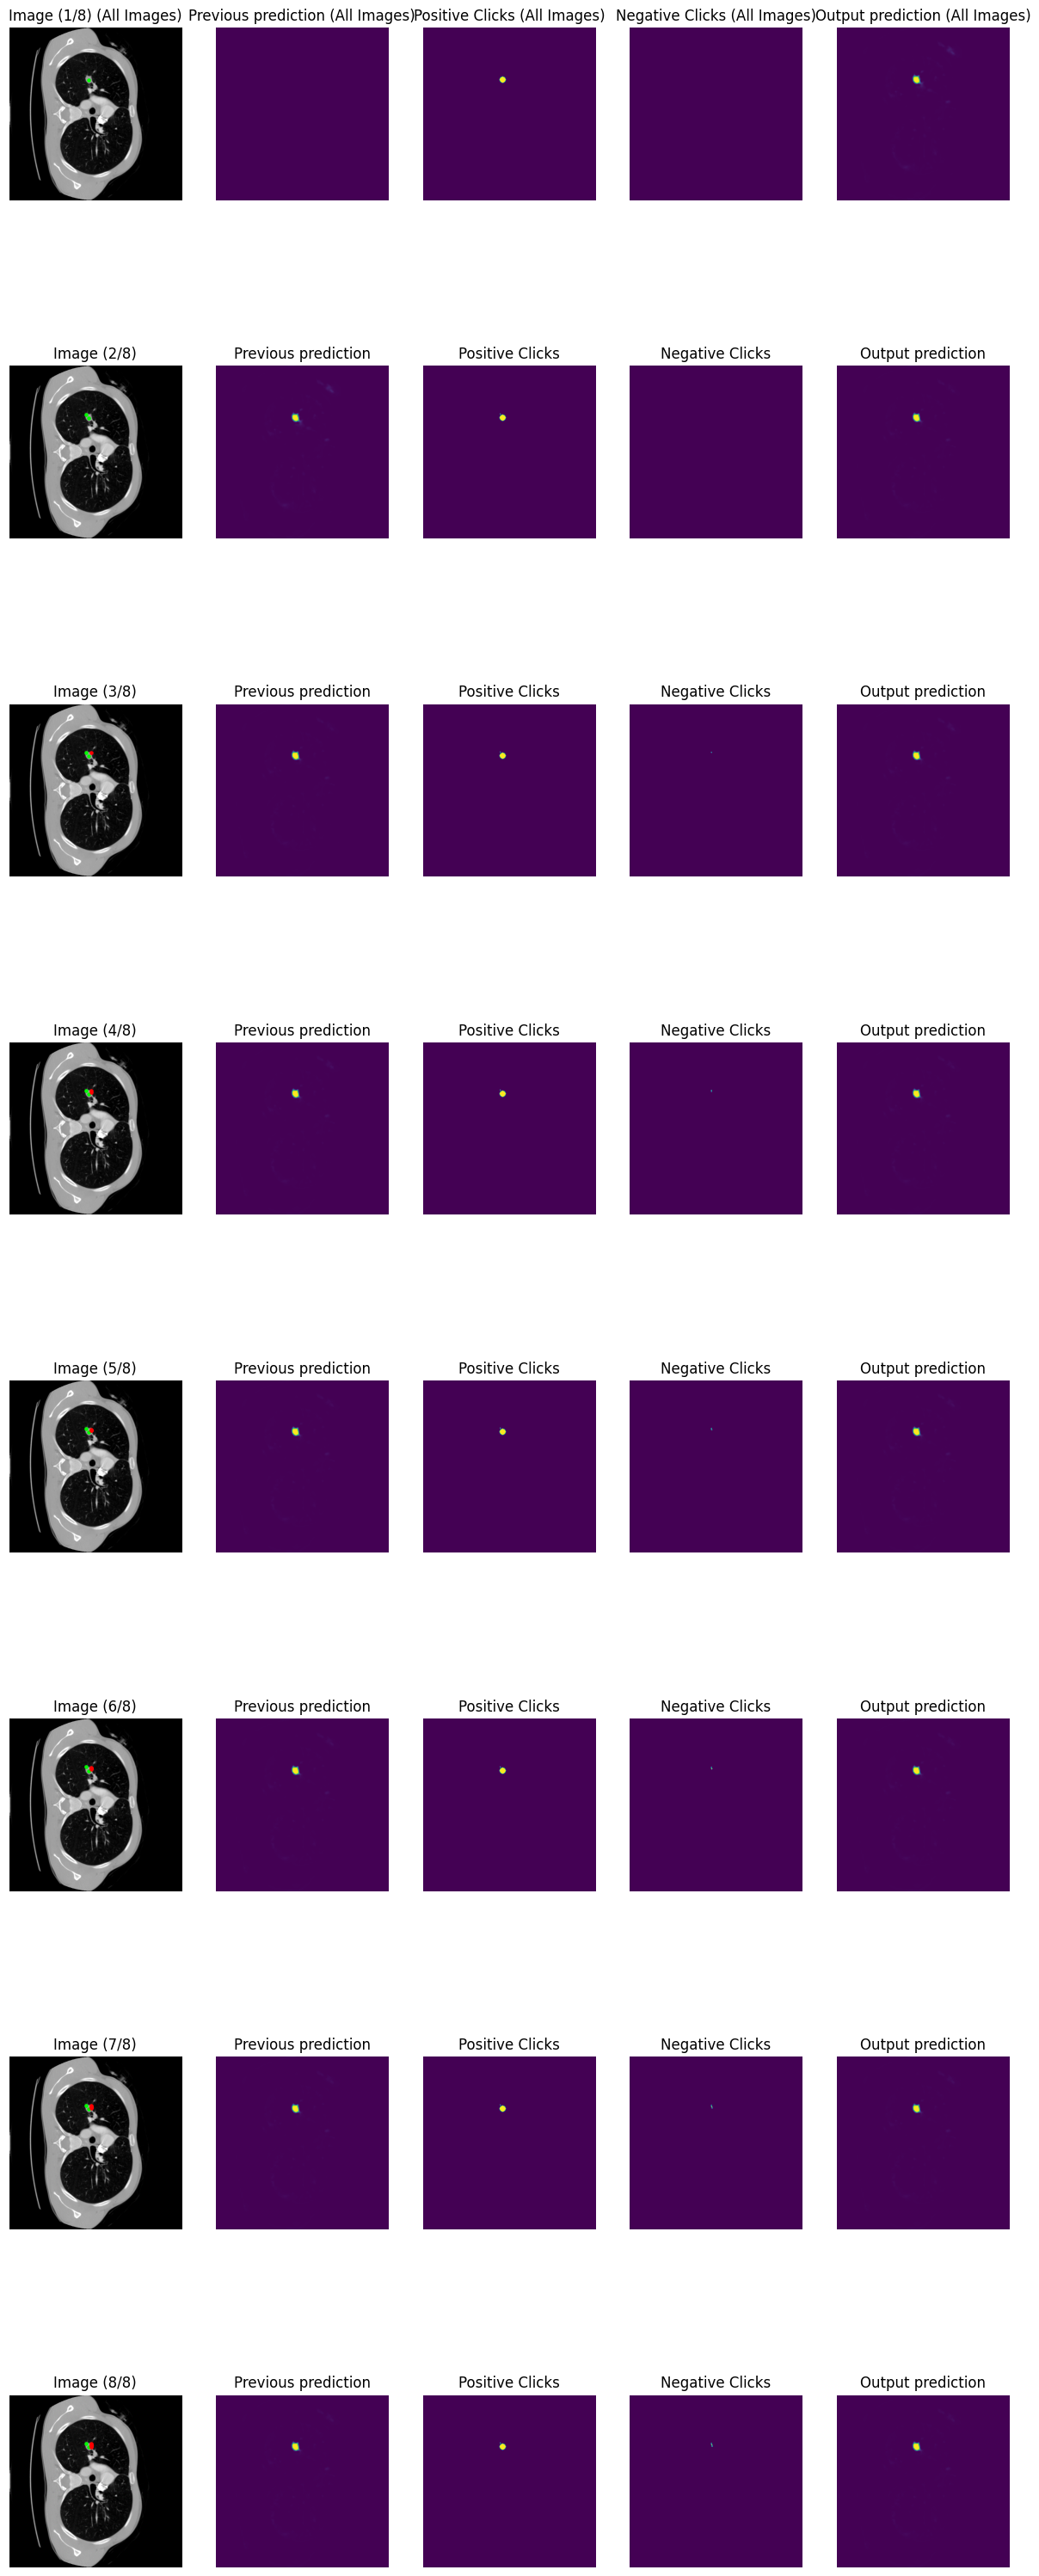

In [182]:
import matplotlib.pyplot as plt

def visualise_coarse_iterations(info, indx=0):
    points = info['input_points'][indx].cpu().numpy()
    half_point = points.shape[0] // 2
    pos_points = points[:half_point]
    neg_points = points[half_point:]
    pos_points = [[point[0], point[1], point[2], True] for point in pos_points if point[0] != -1 and point[2] != 100]
    neg_points = [[point[0], point[1], point[2], False] for point in neg_points if point[0] != -1 and point[2] != 100]
    points = pos_points + neg_points
    points.sort(key=lambda x: x[2])
        
    info = info['inference_info']
    
    num_rows = len(info)
    fig, ax = plt.subplots(num_rows, 5, squeeze=False, figsize=(15, 5*num_rows))
    plt.close()
    
    for i, inf in enumerate(info):
        # Add the click count index to the left of each row
        ax[i, 0].set_title(f"Image ({i+1}/{num_rows})")
        ax[i, 0].imshow(inf['image'][indx, 0, :, :].cpu(), cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].scatter([point[1] for point in points[:i+1] if point[3] == True], [point[0] for point in points[:i+1] if point[3] == True], c='lime', s=5)
        ax[i, 0].scatter([point[1] for point in points[:i+1] if point[3] == False], [point[0] for point in points[:i+1] if point[3] == False], c='red', s=5)

        ax[i, 1].set_title("Previous prediction")
        ax[i, 1].imshow(inf['model_info']['coord_features'].cpu()[indx, 0])
        ax[i, 1].axis('off')
        
        ax[i, 2].imshow(inf['model_info']['coord_features'].cpu()[indx, 1])
        ax[i, 2].axis('off')
        ax[i, 2].set_title('Positive Clicks')
        
        ax[i, 3].imshow(inf['model_info']['coord_features'].cpu()[indx, 2])
        ax[i, 3].axis('off')
        ax[i, 3].set_title('Negative Clicks')

        ax[i, 4].set_title("Output prediction")
        ax[i, 4].imshow(inf['ouput'][indx, 0, :, :].cpu().detach())
        ax[i, 4].axis('off')
    
    # Add titles above the first row
    for j in range(5):
        ax[0, j].set_title(f"{ax[0, j].get_title()} (All Images)")
    
    return fig
    
visualise_coarse_iterations(step_info, indx=0)
